## 1. Data Preparation

In [2]:
# load packages
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(Matrix))
suppressPackageStartupMessages(library(parallel))

All sample data has been processed, R scripts of processing can be found here: 
https://github.com/mora-lab/cell-cell-interactions/tree/main/benchmark-workflow/R

In [9]:
allsample <- c(paste("../Benchmark/Dataset/GSE122960/",list.files("../Benchmark/Dataset/GSE122960/"),sep=""), 
               paste("../Benchmark/Dataset/GSE128033/",list.files("../Benchmark/Dataset/GSE128033/"),sep=""), 
               paste("../Benchmark/Dataset/GSE135893/",list.files("../Benchmark/Dataset/GSE135893/"),sep=""), 
               paste("../Benchmark/Dataset/GSE136831/",list.files("../Benchmark/Dataset/GSE136831/"),sep=""))
length(allsample) # amount of samples

[1] 56

In [8]:
# load gold standard
gold <- read.table("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/data/IPF gold standard.txt", header = TRUE, sep = "\t")
str(gold)
head(gold)

'data.frame':	253 obs. of  4 variables:
 $ source  : chr  "AT1" "AT1" "AT1" "AT1" ...
 $ target  : chr  "Monocyte" "Monocyte" "Monocyte" "Macrophage" ...
 $ ligand  : chr  "TGFB1" "TGFB1" "TGFB1" "TGFB1" ...
 $ receptor: chr  "TGFBR1" "TGFBR2" "TGFBR3" "TGFBR1" ...


,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,AT1,Monocyte,TGFB1,TGFBR1
2,AT1,Monocyte,TGFB1,TGFBR2
3,AT1,Monocyte,TGFB1,TGFBR3
4,AT1,Macrophage,TGFB1,TGFBR1
5,AT1,Macrophage,TGFB1,TGFBR2
6,AT1,Macrophage,TGFB1,TGFBR3


## 2. Cell-cell Interaction Prediction (Python tools)

In [ ]:
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CellPhoneDB process.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/NATMI process.R")
# inputdata preparation
for (sample in allsample){
  seu <- readRDS(sample)
  CellPhoneDB_process(seu,strsplit(strsplit(sample,split="/")[[1]][5],split="\\.")[[1]][1])
  NATMI_process(seu,strsplit(strsplit(sample,split="/")[[1]][5],split="\\.")[[1]][1])
}

### Turn to Bash kernel:

In [1]:
# CellPhoneDB
ls Python/cpdb
ls Python/cpdb/010I/

010I  041I  138I  177I  221I  49I     SC153IPFLOW  SC94IPFUP   TILD028  VUILD64
021I  051I  145I  179I  222I  59I     SC154IPFUP   SC95IPFLOW  VUILD53  VUILD65
022I  053I  157I  209I  225I  IPF_01  SC87IPFLOW   TILD001     VUILD59
025I  063I  158I  210I  228I  IPF_02  SC88IPFUP    TILD006     VUILD60
034I  123I  166I  212I  29I   IPF_03  SC89IPFLOW   TILD010     VUILD61
040I  135I  174I  214I  47I   IPF_04  SC93IPFLOW   TILD015     VUILD63
barcodes.tsv  features.tsv  matrix.mtx  meta.tsv


In [1]:
source activate cpdb

(cpdb) 

: 1

In [4]:
for sample in Python/cpdb/*
do
    mkdir $sample/out
    touch $sample/out/time.txt
	(time -p cellphonedb method statistical_analysis $sample/meta.tsv $sample/ --counts-data hgnc_symbol --output-path $sample/out --threads=4 &>>/dev/null) 2>$sample/out/time.txt 
done

(cpdb) 

: 1

In [5]:
# NATMI
ls Python/natmi
ls Python/natmi/010I/

(cpdb) 010I  041I  138I  177I  221I  49I     SC153IPFLOW  SC94IPFUP   TILD028  VUILD64
021I  051I  145I  179I  222I  59I     SC154IPFUP   SC95IPFLOW  VUILD53  VUILD65
022I  053I  157I  209I  225I  IPF_01  SC87IPFLOW   TILD001     VUILD59
025I  063I  158I  210I  228I  IPF_02  SC88IPFUP    TILD006     VUILD60
034I  123I  166I  212I  29I   IPF_03  SC89IPFLOW   TILD010     VUILD61
040I  135I  174I  214I  47I   IPF_04  SC93IPFLOW   TILD015     VUILD63
(cpdb) ann.csv  em.csv
(cpdb) 

: 1

In [5]:
for sample in Python/natmi/*
do
    mkdir $sample/out
    touch $sample/out/time1.txt
	(time -p docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Test/$sample/:/opt/NATMI/workdir asrhou/natmi python ExtractEdges.py --emFile /opt/NATMI/workdir/em.csv --annFile /opt/NATMI/workdir/ann.csv --interDB lrc2p --out /opt/NATMI/workdir/out &>/dev/null) 2>$sample/out/time1.txt
done

(cpdb) 

: 1

In [6]:
for sample in Python/natmi/*
do
    touch $sample/out/time2.txt
	(time -p docker run --rm -it --name natmi -v /home/bioinformatics/Documents/Test/$sample/:/opt/NATMI/workdir asrhou/natmi python VisInteractions.py --sourceFolder /opt/NATMI/workdir/out --interDB lrc2p --weightType mean --detectionThreshold 0.2 &>/dev/null) 2>$sample/out/time2.txt
done

(cpdb) 

: 1

### Turn back to R kernel:

In [1]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(Matrix))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(iTALK))
suppressPackageStartupMessages(library(CellChat))
suppressPackageStartupMessages(library(SingleCellSignalR))
suppressPackageStartupMessages(library(CCInx))
suppressPackageStartupMessages(library(scMLnet))
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_CellChat.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_iTalk.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_SingleCellSignalR.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_scMLnet.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_CCInx.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_CellPhoneDB.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/run_NATMI.R")
gold <- read.table("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/data/IPF gold standard.txt", header = TRUE, sep = "\t")
allsample <- c(paste("../Benchmark/Dataset/GSE122960/",list.files("../Benchmark/Dataset/GSE122960/"),sep=""), 
               paste("../Benchmark/Dataset/GSE128033/",list.files("../Benchmark/Dataset/GSE128033/"),sep=""), 
               paste("../Benchmark/Dataset/GSE135893/",list.files("../Benchmark/Dataset/GSE135893/"),sep=""), 
               paste("../Benchmark/Dataset/GSE136831/",list.files("../Benchmark/Dataset/GSE136831/"),sep=""))

In [2]:
# CellPhoneDB (threshold: pvalues < 0.05)
cpdblrpairs <- list()
cpdbpairs <- c()
cpdbspeed <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  samplename <- strsplit(strsplit(sample,split="/")[[1]][5],split="\\.")[[1]][1]
  cpdb <- run_CellPhoneDB_output(samplename, seu)
  cpdblrpairs[[sample]] <- cpdb$lrpairs
  cpdbpairs <- c(cpdbpairs, cpdb$pairs)
  cpdbspeed <- rbind(cpdbspeed, cpdb$speed)
}

In [18]:
head(cpdblrpairs[[1]])
sort(cpdbpairs)

,cellA,cellB,geneA,geneB
,<chr>,<chr>,<chr>,<chr>
1,AT1,AT1,WNT3A,FZD2
2,AT1,AT1,NOTCH3,JAG2
3,AT1,AT1,WNT5A,FZD2
4,AT1,AT1,CEACAM6,CEACAM6
5,AT1,AT1,EGFR,TGFA
6,AT1,AT1,EPHA1,EFNA5


[1]  311  510  604  682  856  905  933  943  963 1062 1120 1140 1160 1185 1246
[16] 1324 1351 1389 1394 1416 1444 1457 1521 1545 1563 1576 1657 1689 1746 1792
[31] 1809 1857 1878 1909 1939 1979 1993 2030 2164 2178 2258 2263 2281 2285 2303
[46] 2362 2398 2404 2432 2631 2844 3029 3035 3153 3363 3510

In [4]:
# NATMI (threshold: do not draw the interactions in which detection rates of the ligand and the receptor are lower than the threshold (default 0.2))
nmlrpairs <- list()
nmpairs <- c()
nmspeed <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  samplename <- strsplit(strsplit(sample,split="/")[[1]][5],split="\\.")[[1]][1]
  nm <- run_NATMI_output(samplename, seu)
  nmlrpairs[[sample]] <- nm$lrpairs
  nmpairs <- c(nmpairs, nm$pairs)
  nmspeed <- rbind(nmspeed, nm$speed)
}

In [19]:
head(nmlrpairs[[1]])
sort(nmpairs)

,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,Endothelial,AT1,A2M,LRP1
2,Endothelial,Fibroblast,A2M,LRP1
3,Endothelial,Macrophage,A2M,LRP1
4,Endothelial,Monocyte,A2M,LRP1
5,Fibroblast,AT1,A2M,LRP1
6,Fibroblast,Fibroblast,A2M,LRP1


[1]   81 1161 1683 1892 2228 2313 2331 2455 2475 2501 2541 2614 2702 2729 2867
[16] 2883 2906 2935 3032 3088 3152 3169 3237 3346 3376 3448 3472 3542 3573 3643
[31] 3656 3789 3822 3867 3927 4104 4185 4295 4311 4346 4556 4558 4622 4694 4819
[46] 4916 4920 5187 5250 5349 5450 5659 6221 6473 6817 7163

In [6]:
cpdbunlist <- data.frame()
for(i in 1:length(cpdblrpairs)){
  cpdbunlist <- rbind(cpdbunlist, cpdblrpairs[[i]])
}
nmunlist <- data.frame()
for(i in 1:length(nmlrpairs)){
  nmunlist <- rbind(nmunlist, nmlrpairs[[i]])
}
saveRDS(cpdblrpairs,"Result/lrpairs/cpdb.rds")
saveRDS(nmlrpairs,"Result/lrpairs/nm.rds")
write.table(unique(cpdbunlist),"Result/lrpairs/cpdb.txt",row.names = F,sep="\t",quote = F)
write.table(unique(nmunlist),"Result/lrpairs/nm.txt",row.names = F,sep="\t",quote = F)

In [7]:
cpdbspeed[,"Tool"] <- rep("CellPhoneDB",each=56)
write.table(cpdbspeed,"Result/speedcpdb.txt",row.names = F,sep="\t",quote = F)
nmspeed[,"Tool"] <- rep("NATMI",each=56)
write.table(nmspeed,"Result/speednm.txt",row.names = F,sep="\t",quote = F)

## 3. Cell-cell Interaction Prediction (R tools) 

In [ ]:
# CellChat
cclrpairs <- list()
ccpairs <- c()
ccspeed <- data.frame()

for (sample in allsample){
  seu <- readRDS(sample)
  cc <- run_CellChat(seu)
  cclrpairs[[sample]] <- cc$lrpairs
  ccpairs <- c(ccpairs, cc$pairs)
  ccspeed <- rbind(ccspeed, cc$speed)
}

In [17]:
head(cclrpairs[[1]])
sort(ccpairs)

,source,target,ligand,receptor,prob,pval
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,Macrophage,AT1,TGFB1,TGFBR1,0.007129617,0.00
2,Macrophage,AT1,TGFB1,TGFBR2,0.007129617,0.00
21,Monocyte,AT1,TGFB1,TGFBR1,0.005411899,0.00
22,Monocyte,AT1,TGFB1,TGFBR2,0.005411899,0.00
3,Tcell,AT1,TGFB1,TGFBR1,0.001918807,0.02
31,Tcell,AT1,TGFB1,TGFBR2,0.001918807,0.02


[1]  263  504  546  547  553  557  613  747  775  781  824  861  868  916  917
[16]  946  959 1025 1063 1154 1169 1195 1227 1238 1265 1290 1291 1303 1333 1334
[31] 1394 1523 1569 1577 1584 1611 1661 1663 1789 1811 1828 1882 1910 1975 1988
[46] 2002 2056 2124 2256 2389 2463 2637 2667 2668 2972 3928

In [7]:
ccunlist <- data.frame()
for(i in 1:length(cclrpairs)){
  ccunlist <- rbind(ccunlist,cclrpairs[[i]])
}
speed <- ccspeed
speed[,"Tool"] <- rep("CellChat",each=56)
saveRDS(cclrpairs,"Result/lrpairs/cc.rds")
write.table(unique(ccunlist),"Result/lrpairs/cc.txt",row.names = F,sep="\t",quote = F)
write.table(speed,"Result/speedcc.txt",row.names = F,sep="\t",quote = F)

In [ ]:
# SingleCellSignalR (threshold: LRscore > 0.5)
scsrlrpairs <- list()
scsrpairs <- c()
scsrspeed <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  scsr <- run_SingleCellSignalR(seu)
  scsrlrpairs[[sample]] <- scsr$lrpairs
  scsrpairs <- c(scsrpairs, scsr$pairs)
  scsrspeed <- rbind(scsrspeed, scsr$speed)
}

In [16]:
head(scsrlrpairs[[1]])
sort(scsrpairs)

,source,target,ligand,receptor,LRscore
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Macrophage,Fibroblast,ITGB2,THY1,0.877743030821886
2,Macrophage,Fibroblast,PSAP,GPR37,0.82495066346123
3,Macrophage,Fibroblast,CALM1,GLP2R,0.824195486159842
4,Macrophage,Fibroblast,CALM1,CACNA1C,0.808674990337557
5,Macrophage,Fibroblast,CALM2,CACNA1C,0.794538482286129
6,Macrophage,Fibroblast,UBA52,AGTR1,0.768067138619483


[1]  858 1156 1757 1876 1951 2081 2108 2305 2426 2434 2488 2648 2689 2875 2879
[16] 2909 2942 2987 3000 3055 3056 3056 3098 3110 3114 3127 3285 3289 3677 3682
[31] 3774 3811 3874 3946 3949 3957 3962 4075 4213 4296 4317 4457 4478 4495 4515
[46] 4538 4549 4590 4650 4842 4847 4914 4928 5137 5434 5481

In [13]:
scsrunlist <- data.frame()
for(i in 1:length(scsrlrpairs)){
  scsrunlist <- rbind(scsrunlist, scsrlrpairs[[i]])
}
speed <- scsrspeed
speed[,"Tool"] <- rep("SingleCellSignalR",each=56)
saveRDS(scsrlrpairs,"Result/lrpairs/scsr.rds")
write.table(unique(scsrunlist),"Result/lrpairs/scsr.txt",row.names = F,sep="\t",quote = F)
write.table(speed,"Result/speedscsr.txt",row.names = F,sep="\t",quote = F)

In [ ]:
# scMLnet
sclrpairs <- list()
scpairs <- c()
scspeed <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  sc <- run_scMLnet(seu)
  sclrpairs[[sample]] <- sc$lrpairs
  scpairs <- c(scpairs, sc$pairs)
  scspeed <- rbind(scspeed, sc$speed)
}

In [8]:
head(sclrpairs[[1]])
sort(scpairs)

,source,target,ligand,receptor
,<chr>,<chr>,<chr>,<chr>
1,Macrophage,Fibroblast,ADAM17,ITGB1
2,Macrophage,Fibroblast,APOE,LDLR
3,Macrophage,Fibroblast,BST1,CAV1
4,Macrophage,Fibroblast,CALM1,CACNA1C
5,Macrophage,Fibroblast,CALM1,FAS
6,Macrophage,Fibroblast,CALM1,MYLK


[1]  13  19  60 101 128 133 135 137 142 155 159 167 168 172 180 204 224 269 309
[20] 314 322 329 337 350 405 416 423 469 516 523 560 576 588 591 600 628 642 662
[39] 692 711 712 729 742 757 792 830 835 837 847 857 866 888 899 911 933 973

In [ ]:
scunlist <- data.frame()
for(i in 1:length(sclrpairs)){
  scunlist <- rbind(scunlist, sclrpairs[[i]])
}
speed <- scspeed
speed[,"Tool"] <- rep("scMLnet",each=56)
saveRDS(sclrpairs,"Result/lrpairs/sc.rds")
write.table(unique(scunlist),"Result/lrpairs/sc.txt",row.names = F,sep="\t",quote = F)
write.table(speed,"Result/speedsc.txt",row.names = F,sep="\t",quote = F)

In [12]:
# choose max counts of predicted pairs from each tools for the thresholds of iTalk and CCInx 
maxpairs <- c()
for(i in 1:56){
    pairs <- c(nrow(cclrpairs[[i]]),nrow(scsrlrpairs[[i]]),nrow(sclrpairs[[i]]),nrow(cpdblrpairs[[i]]),nrow(nmlrpairs[[i]]))
    maxpairs <- c(maxpairs, max(pairs))
}

In [13]:
maxpairs

[1] 6221 2362 5450 4479 2988 2910 2883 2729 3448 3169 3111 3376 3867 3678 4915
[16] 6473 4556 3237 3346 4458 4318 1683 3947 2649 4295 5349 4346 2943 4929 5659
[31] 4558 5187 3152 4651 3542 5435 6817 5482 5250 4214 5138 4622 4843 3875 2489
[46] 1892 2455 3775 3950 4694 4539 4496 7163 3812 3472 4920

In [ ]:
# iTalk
itlrpairs <- list()
itpairs <- c()
itspeed <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  it <- run_iTalk(seu,top=maxpairs[which(allsample == sample)])
  itlrpairs[[sample]] <- it$lrpairs
  itpairs <- c(itpairs, it$pairs)
  itspeed <- rbind(itspeed, it$speed)
}

In [10]:
head(itlrpairs[[1]])
sort(itpairs)

,source,target,ligand,receptor,source_mean_exprs,target_mean_exprs
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
53670,Fibroblast,Mast,TIMP1,CD63,3.314967,3.196757
53663,Fibroblast,Macrophage,TIMP1,CD63,3.314967,3.046885
53665,Fibroblast,AT2,TIMP1,CD63,3.314967,3.005990
56794,Mast,Mast,VIM,CD44,3.789329,2.403018
433210,Tcell,Tcell,B2M,CD3D,5.015877,1.813628
56738,Macrophage,Mast,VIM,CD44,3.631689,2.403018


[1] 1683 1892 2362 2455 2489 2649 2729 2883 2910 2943 2988 3111 3152 3169 3237
[16] 3346 3376 3448 3472 3542 3678 3775 3812 3867 3875 3947 3950 4214 4295 4318
[31] 4346 4458 4479 4496 4539 4556 4558 4622 4651 4694 4843 4915 4920 4929 5138
[46] 5187 5250 5349 5435 5450 5482 5659 6221 6473 6817 7163

In [20]:
itunlist <- data.frame()
for(i in 1:length(itlrpairs)){
  itunlist <- rbind(itunlist,itlrpairs[[i]])
}
speed <- itspeed
speed[,"Tool"] <- rep("iTalk",each=56)
saveRDS(itlrpairs,"Result/lrpairs/it.rds")
write.table(unique(itunlist),"Result/lrpairs/it.txt",row.names = F,sep="\t",quote = F)
write.table(speed,"Result/speedit.txt",row.names = F,sep="\t",quote = F)

In [ ]:
# CCInx
ccilrpairs <- list()
ccipairs <- c()
ccispeed <- data.frame()
for (sample in allsample){
  seu <- readRDS(sample)
  cci <- run_CCInx(seu,top=maxpairs[which(allsample == sample)])
  ccilrpairs[[sample]] <- cci$lrpairs
  ccipairs <- c(ccipairs, cci$pairs)
  ccispeed <- rbind(ccispeed, cci$speed)
}

In [15]:
head(ccilrpairs[[1]])
sort(ccipairs)

,source,target,ligand,receptor,edgeWeight
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Monocyte,Monocyte,B2M,HLA-B,0.913361190607574
2,Monocyte,Monocyte,B2M,HLA-B,0.913361190607574
3,Tcell,Monocyte,B2M,HLA-B,0.896520110062901
4,Monocyte,Tcell,B2M,HLA-B,0.890588329689869
5,Monocyte,Monocyte,B2M,HLA-C,0.888210812196087
6,Monocyte,Monocyte,B2M,HLA-C,0.888210812196087


[1]    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
[16]    0 2361 2488 2728 2882 2909 2987 3110 3168 3345 3375 3447 3677 3774 3811
[31] 3866 3949 4213 4294 4317 4345 4457 4478 4495 4538 4555 4621 4693 4842 4914
[46] 4928 5137 5186 5249 5348 5434 5449 5481 5658 6220 6472

In [23]:
cciunlist <- data.frame()
for(i in 1:length(ccilrpairs)){
  cciunlist <- rbind(cciunlist, ccilrpairs[[i]])
}
speed <- ccispeed
speed[,"Tool"] <- rep("CCInx",each=56)
saveRDS(ccilrpairs,"Result/lrpairs/cci.rds")
write.table(unique(cciunlist),"Result/lrpairs/cci.txt",row.names = F,sep="\t",quote = F)
write.table(speed,"Result/speedcci.txt",row.names = F,sep="\t",quote = F)

## 4. Results

In [20]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(tidyverse))
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/SSP.R")
source("https://raw.githubusercontent.com/mora-lab/cell-cell-interactions/main/benchmark-workflow/R/CellPhoneDB_SSP.R")

In [38]:
# time consuming
files <- paste("Result/",dir("Result",pattern = "^speed"),sep = "")
time <- map(files, ~ read.table(.,sep = "\t",header = TRUE))
total <- as.data.frame(do.call(rbind,time))
total <- total[!is.na(total$time),]
table(total$Tool)


            CCInx          CellChat       CellPhoneDB             iTalk 
               40                56                56                56 
            NATMI           scMLnet SingleCellSignalR 
               56                56                56 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 265 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 265 rows containing missing values (geom_point).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 265 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 265 rows containing missing values (geom_point).”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 113 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 113 rows containing missing values (geom_point).”


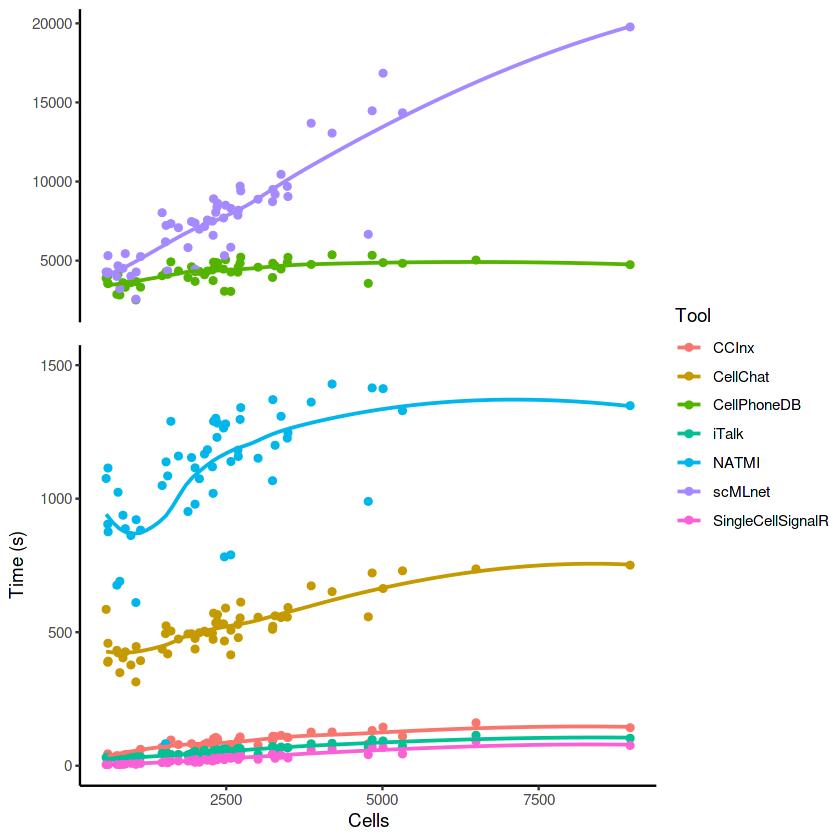

In [51]:
p1 <- ggplot(data=total, aes(x=cells, y=time)) + 
  geom_point(aes(color = Tool)) + 
  stat_smooth(aes(color = Tool), se=FALSE, size=0.8) +
  labs(x="Cells", y="Time (s)") + ylim(c(0,1500)) + theme_classic()
p2 <- ggplot(data=total, aes(x=cells, y=time)) + 
  geom_point(aes(color = Tool)) + stat_smooth(aes(color = Tool), se=FALSE, size=0.8) +
  labs(x=NULL,y=NULL,fill=NULL) + ylim(c(2000,20000)) + theme_classic() +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.line.x = element_blank())
ggarrange(p2,p1,heights=c(2/5,3/5),ncol=1,nrow=2,common.legend=TRUE,legend="right",align="v")

In [53]:
ggsave("Result/time.pdf", width=10,height=8)

In [133]:
# building all pairs
files <- dir("Result/lrpairs",pattern = "[^db].txt$", full.names = TRUE)
pairs <- map(files, ~ read.table(.,sep = "\t",header = TRUE)[,1:4])
allpairs <- unique(as.data.frame(do.call(rbind,pairs)))
types <- as.character(unique(c(gold$source,gold$target)))
list <- unique(gold[,3:4])
singlelist <- data.frame(source=NA, target=NA)
goldpairs <- data.frame()
for(i in 1:length(types)){
  cellA <- types[i]
  for(n in 1:length(types)){
    cellB <- types[n]
    singlelist[c(1:nrow(list)),1] <- cellA
    singlelist[c(1:nrow(list)),2] <- cellB
    singlelist <- cbind(singlelist, list)
    goldpairs <- rbind(goldpairs, singlelist)
    singlelist <- data.frame(source=NA, target=NA)
  }
}
allpairs <- unique(rbind(allpairs,goldpairs))
cpdb <- read.table("Result/lrpairs/cpdb.txt", header = TRUE, sep = "\t")
rvcpdb <- cpdb[,c(2,1,4,3)]
colnames(rvcpdb) <- c("source","target","ligand","receptor")
colnames(cpdb) <- c("source","target","ligand","receptor")
allpairs <- unique(rbind(allpairs,cpdb)[!duplicated(rbind(allpairs,rvcpdb)),])
str(allpairs)
write.table(allpairs, "Result/lrpairs/allpairs.txt", sep = "\t", quote = FALSE, row.names = FALSE)

'data.frame':	92323 obs. of  4 variables:
 $ source  : chr  "Macrophage" "Macrophage" "Monocyte" "Monocyte" ...
 $ target  : chr  "AT1" "AT1" "AT1" "AT1" ...
 $ ligand  : chr  "TGFB1" "TGFB1" "TGFB1" "TGFB1" ...
 $ receptor: chr  "TGFBR1" "TGFBR2" "TGFBR1" "TGFBR2" ...


In [180]:
# SSP calculation
cc <- readRDS("Result/lrpairs/cc.rds") %>% lapply(., function(x){run_SSP(x,allpairs,gold)}) %>% do.call(rbind,.) %>% as.data.frame(,row.names = FALSE)
cc[,"Tool"] <- rep("CellChat",each=56)
head(cc)
it <- readRDS("Result/lrpairs/it.rds") %>% lapply(., function(x){run_SSP(x,allpairs,gold)}) %>% do.call(rbind,.) %>% as.data.frame(,row.names = FALSE)
it[,"Tool"] <- rep("iTalk",each=56)
head(it)
scsr <- readRDS("Result/lrpairs/scsr.rds") %>% lapply(., function(x){run_SSP(x,allpairs,gold)}) %>% do.call(rbind,.) %>% as.data.frame(,row.names = FALSE)
scsr[,"Tool"] <- rep("SingleCellSignalR",each=56)
head(scsr)
cci <- readRDS("Result/lrpairs/cci.rds") %>% lapply(., function(x){run_SSP(x,allpairs,gold)}) %>% do.call(rbind,.) %>% as.data.frame(,row.names = FALSE)
cci[,"Tool"] <- rep("CCInx",each=56)
head(cci)
sc <- readRDS("Result/lrpairs/sc.rds") %>% lapply(., function(x){run_SSP(x,allpairs,gold)}) %>% do.call(rbind,.) %>% as.data.frame(,row.names = FALSE)
sc[,"Tool"] <- rep("scMLnet",each=56)
head(sc)
cpdb <- readRDS("Result/lrpairs/cpdb.rds") %>% lapply(., function(x){run_CellPhoneDB_SSP(x,allpairs,gold)}) %>% do.call(rbind,.) %>% as.data.frame(,row.names = FALSE)
cpdb[,"Tool"] <- rep("CellPhoneDB",each=56)
head(cpdb)
nm <- readRDS("Result/lrpairs/nm.rds") %>% lapply(., function(x){run_SSP(x,allpairs,gold)}) %>% do.call(rbind,.) %>% as.data.frame(,row.names = FALSE)
nm[,"Tool"] <- rep("NATMI",each=56)
head(nm)

,Precision,Sensitivity,Specificity,F1score,MCC,NPV,Tool
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<chr>
1,0.01055195,0.1027668,0.9735201,0.01913876,0.02474392,0.9974738,CellChat
2,0.004962779,0.03162055,0.9825785,0.008579088,0.005667159,0.9972991,CellChat
3,0.008917197,0.05533597,0.9830998,0.0153593,0.01554085,0.9973665,CellChat
4,0,0,0.9971326,0,-0.002807178,0.9972518,CellChat
5,0.00436205,0.01581028,0.9900836,0.006837607,0.003107068,0.9972759,CellChat
6,0.006960557,0.02371542,0.9907027,0.01076233,0.007837129,0.9972994,CellChat


,Precision,Sensitivity,Specificity,F1score,MCC,NPV,Tool
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<chr>
1,0.007715801,0.1897233,0.9329532,0.01482854,0.02558256,0.9976191,iTalk
2,0.00127011,0.01185771,0.9743782,0.002294455,-0.004557221,0.997221,iTalk
3,0.004220183,0.09090909,0.9410557,0.00806593,0.007090074,0.9973525,iTalk
4,0.004911811,0.08695652,0.9515912,0.009298394,0.009379318,0.9973703,iTalk
5,0.004016064,0.04743083,0.9676768,0.007405122,0.004462864,0.9973023,iTalk
6,0.005841924,0.06719368,0.9685783,0.01074929,0.01070323,0.9973606,iTalk


,Precision,Sensitivity,Specificity,F1score,MCC,NPV,Tool
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<chr>
1,0.006944444,0.07905138,0.9689367,0.01276732,0.01443056,0.997395,SingleCellSignalR
2,0.004770165,0.04347826,0.9750733,0.008597108,0.006214529,0.9973116,SingleCellSignalR
3,0.00511509,0.06324111,0.9661996,0.009464655,0.008506764,0.9973429,SingleCellSignalR
4,0.002902434,0.0513834,0.9514934,0.005494505,0.0006999817,0.9972679,SingleCellSignalR
5,0.004016064,0.04743083,0.9676768,0.007405122,0.004462864,0.9973023,SingleCellSignalR
6,0.005841924,0.06719368,0.9685783,0.01074929,0.01070323,0.9973606,SingleCellSignalR


,Precision,Sensitivity,Specificity,F1score,MCC,NPV,Tool
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<chr>
1,0.0004822376,0.01185771,0.9324644,0.0009267841,-0.01161088,0.9970965,CCInx
2,0,0,0.9743456,0,-0.008494034,0.9971877,CCInx
3,0.0001834862,0.003952569,0.9408168,0.0003506926,-0.01225064,0.9970992,CCInx
4,0.0006697924,0.01185771,0.9513848,0.001267963,-0.008943725,0.997154,CCInx
5,0.001004016,0.01185771,0.967579,0.00185128,-0.0060745,0.9972015,CCInx
6,0.0003436426,0.003952569,0.9684045,0.0006323111,-0.00827098,0.9971816,CCInx


,Precision,Sensitivity,Specificity,F1score,MCC,NPV,Tool
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<chr>
1,0.0192926,0.07114625,0.9900619,0.03035413,0.03199178,0.9974286,scMLnet
2,0.01463964,0.0513834,0.9904964,0.02278703,0.02243163,0.9973752,scMLnet
3,0.01969058,0.05533597,0.9924297,0.02904564,0.02856432,0.9973912,scMLnet
4,0,0,0.9982731,0,-0.002177304,0.9972549,scMLnet
5,0.01317234,0.04743083,0.9902357,0.02061856,0.01992113,0.9973636,scMLnet
6,0.02289157,0.07509881,0.9911915,0.03508772,0.03671439,0.9974424,scMLnet


,Precision,Sensitivity,Specificity,F1score,MCC,NPV,Tool
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<chr>
1,0.0174437,0.2173913,0.9663517,0.03229595,0.0528882,0.9977795,CellPhoneDB
2,0.02074513,0.1936759,0.9748778,0.0374761,0.05580724,0.9977324,CellPhoneDB
3,0.02179276,0.2094862,0.974161,0.03947858,0.05994647,0.9977751,CellPhoneDB
4,0.03215434,0.03952569,0.9967307,0.03546099,0.03271162,0.997359,CellPhoneDB
5,0.02807018,0.1264822,0.9879657,0.04594401,0.05417735,0.9975763,CellPhoneDB
6,0.02241379,0.1027668,0.9876833,0.03680113,0.0424512,0.99751,CellPhoneDB


,Precision,Sensitivity,Specificity,F1score,MCC,NPV,Tool
,<named list>,<named list>,<named list>,<named list>,<named list>,<named list>,<chr>
1,0.01430638,0.3517787,0.9333985,0.02749459,0.05946992,0.9980953,NATMI
2,0,0,0.9991202,0,-0.001553386,0.9972572,NATMI
3,0.0133945,0.2885375,0.9415988,0.02560056,0.05104625,0.997928,NATMI
4,0,0,0.98739,0,-0.005915758,0.9972247,NATMI
5,0.01185922,0.1225296,0.9719453,0.02162539,0.02977591,0.9975253,NATMI
6,0.01454545,0.1422925,0.9735093,0.02639296,0.03747941,0.9975848,NATMI


In [128]:
# remove error results produced by CCInx
cci <- read.table("Result/speedcci.txt",sep = "\t",header = TRUE)
ccierror <- which(is.na(cci[,2]))
ccierror

[1] 18 22 23 24 28 31 33 34 35 37 44 46 47 53 55 56

In [181]:
ssp <- rbind(cc,it,scsr,cci[-ccierror,],sc,cpdb,nm)
ssp[,1:7] <- unlist(ssp[,1:7])
ssp[,1] <- as.numeric(ssp[,1])
ssp[,2] <- as.numeric(ssp[,2])
ssp[,3] <- as.numeric(ssp[,3])
ssp[,4] <- as.numeric(ssp[,4])
ssp[,5] <- as.numeric(ssp[,5])
ssp[,6] <- as.numeric(ssp[,6])
str(ssp)
write.table(ssp, "Result/ssp.txt", sep = "\t", quote = FALSE, row.names = FALSE)

'data.frame':	376 obs. of  7 variables:
 $ Precision  : num  0.01055 0.00496 0.00892 0 0.00436 ...
 $ Sensitivity: num  0.1028 0.0316 0.0553 0 0.0158 ...
 $ Specificity: num  0.974 0.983 0.983 0.997 0.99 ...
 $ F1score    : num  0.01914 0.00858 0.01536 0 0.00684 ...
 $ MCC        : num  0.02474 0.00567 0.01554 -0.00281 0.00311 ...
 $ NPV        : num  0.997 0.997 0.997 0.997 0.997 ...
 $ Tool       : chr  "CellChat" "CellChat" "CellChat" "CellChat" ...


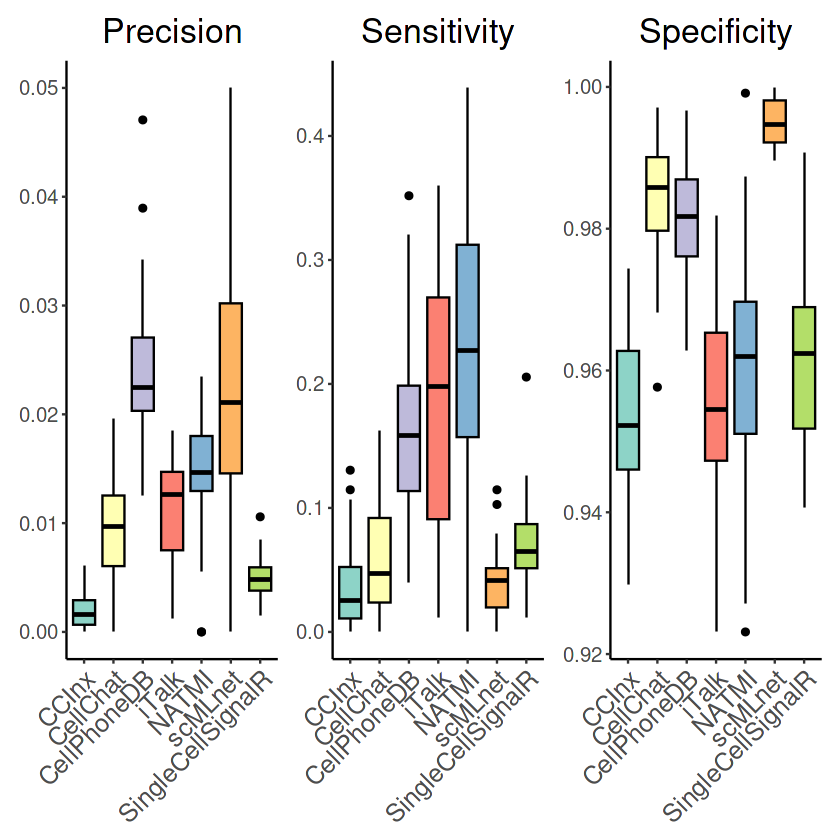

In [194]:
p1 <- ggplot(data=ssp, aes(x=Tool, y=Precision)) + geom_boxplot(color="black", aes(fill=Tool)) + scale_fill_brewer(palette = "Set3") + theme_classic() + labs(x=NULL,y=NULL,title="Precision") + theme(axis.text.x = element_text(angle = 45, size=15, vjust=1, hjust=1), axis.text.y = element_text(size = 12), plot.title = element_text(hjust = .5, size = 20),legend.position="none")
p2 <- ggplot(data=ssp, aes(x=Tool, y=Sensitivity)) + geom_boxplot(color="black", aes(fill=Tool)) + scale_fill_brewer(palette = "Set3") + theme_classic() + labs(x=NULL,y=NULL,title="Sensitivity") + theme(axis.text.x = element_text(angle = 45, size=15, vjust=1, hjust=1), axis.text.y = element_text(size = 12), plot.title = element_text(hjust = .5, size = 20),legend.position="none")
p3 <- ggplot(data=ssp, aes(x=Tool, y=Specificity)) + geom_boxplot(color="black", aes(fill=Tool)) + scale_fill_brewer(palette = "Set3") + theme_classic() + labs(x=NULL,y=NULL,title="Specificity") + theme(axis.text.x = element_text(angle = 45, size=15, vjust=1, hjust=1), axis.text.y = element_text(size = 12), plot.title = element_text(hjust = .5, size = 20),legend.position="none")
p1+p2+p3

In [ ]:
ggsave("Result/ssp.pdf", width=15,height=6)

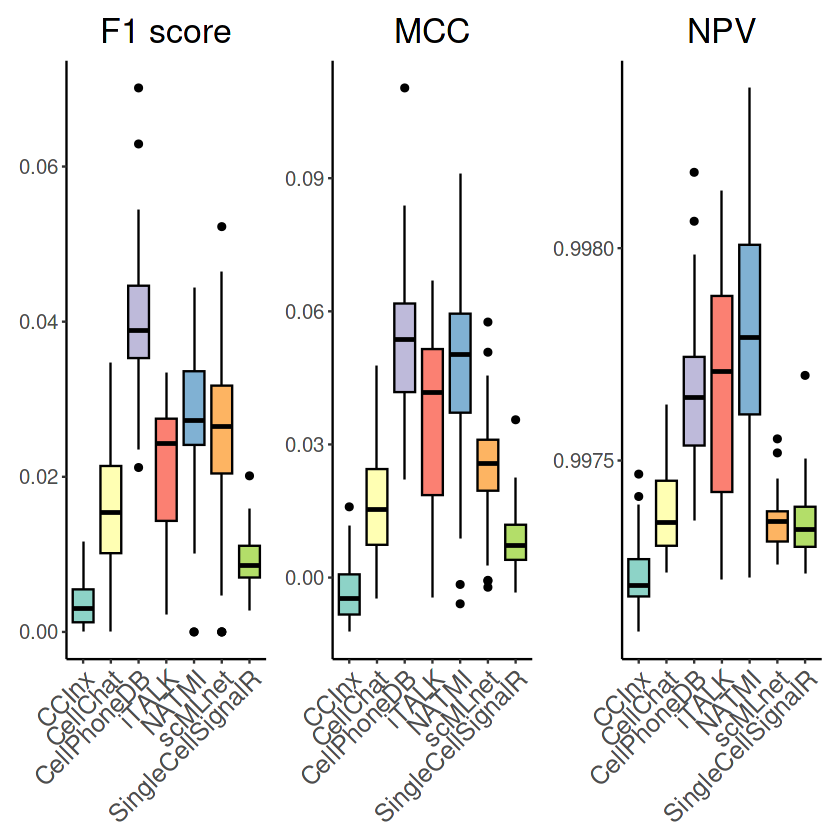

In [23]:
p4 <- ggplot(data=ssp, aes(x=Tool, y=F1score)) + geom_boxplot(color="black", aes(fill=Tool)) + scale_fill_brewer(palette = "Set3") + theme_classic() + labs(x=NULL,y=NULL,title="F1 score") + theme(axis.text.x = element_text(angle = 45, size=15, vjust=1, hjust=1), axis.text.y = element_text(size = 12), plot.title = element_text(hjust = .5, size = 20),legend.position="none")
p5 <- ggplot(data=ssp, aes(x=Tool, y=MCC)) + geom_boxplot(color="black", aes(fill=Tool)) + scale_fill_brewer(palette = "Set3") + theme_classic() + labs(x=NULL,y=NULL,title="MCC") + theme(axis.text.x = element_text(angle = 45, size=15, vjust=1, hjust=1), axis.text.y = element_text(size = 12), plot.title = element_text(hjust = .5, size = 20),legend.position="none")
p6 <- ggplot(data=ssp, aes(x=Tool, y=NPV)) + geom_boxplot(color="black", aes(fill=Tool)) + scale_fill_brewer(palette = "Set3") + theme_classic() + labs(x=NULL,y=NULL,title="NPV") + theme(axis.text.x = element_text(angle = 45, size=15, vjust=1, hjust=1), axis.text.y = element_text(size = 12), plot.title = element_text(hjust = .5, size = 20),legend.position="none")
p4+p5+p6

In [196]:
ggsave("Result/f1mcc.pdf", width=12,height=12)

In [24]:
sessionInfo()

R version 4.2.2 Patched (2022-11-10 r83330)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] forcats_0.5.1           stringr_1.4.0           purrr_0.3.4            
 [4] readr_2.1.2             tidyr_1.2.0             tibble_3.1.7           
 [7] tidyverse_1.3.1         ggpubr_0.5.0            scMLnet_0.1.0          
[10] CCI

Last updated: 2023.2.7